# Approach 1

This approach was initially implemented to work as a commandline too where the prompt would be passed as a file

In [1]:
import mmh3
import sys
import os
import pickle
import json
from tqdm import tqdm
import pandas as pd
import numpy as np
from utils import get_referenced_by, filter_df, clean_text
from dataloader import CitationDataset
from pandarallel import pandarallel

In [2]:
def shingle(text: str, shingle_size):
        text_list = text.split()
        return list(set(" ".join(text_list[i:i+shingle_size]) for i in range(len(text_list)-shingle_size+1)))
    
def minhash(text_list, seed) -> int:
    hash_list = [mmh3.hash(shingle, seed) for shingle in text_list] 
    return min(hash_list)

def get_signature(text: str, shingle_size = 3, sig_len = 50):    
    shingle_list = shingle(text, shingle_size)
    if len(shingle_list) == 0:
        return np.nan
    try:
        signature = [minhash(shingle_list, seed) for seed in range(sig_len)]
    except  Exception as e:
        print(text)
        print(shingle_list)
        sys.exit(e)
    return signature


def get_model(save_path: str, shingle_size=2, signature_size=250, subset=False) -> pd.DataFrame:
    """ Loads model from cache or creates it from scratch using the given parameters
    based on the dataset from the dataloader. 

    Args:
        save_path (str): Path to cache file
        shingle_size (int, optional): Size to shingle the abstracts to. Defaults to 2.
        signature_size (int, optional): length of the signature. Defaults to 250.
        subset (bool, optional): Whether to use a smaller model for demonstration. Defaults to False.

    Returns:
        pd.DataFrame: dataframe containing the signatures and other information
    """
    if os.path.exists(save_path):
        print("Loading cached dataframe...")
        with open(save_path, "rb") as f:
            df = pickle.load(f)
    else:
        print("Loading dataframe...")
        dataset = CitationDataset()
        df = dataset.load_dataframe(subset=subset)
        
        # get and count the internal references
        df = get_referenced_by(df)
        print("Filtering dataframe...")
        df = filter_df(df)

        print("Calculating signatures...")
        df["signature"] = df["abstract"].parallel_apply(get_signature, 
                                                        shingle_size=shingle_size, 
                                                        sig_len=signature_size)
        with open(save_path, "wb") as f:
            pickle.dump(df, f)
    return df


def jaccard(signature1, signature2):
    import numpy as np

    if signature1 == np.nan or signature2 == np.nan:
        return 0

    signatures_doc1 = np.array(signature1)
    signatures_doc2 = np.array(signature2)
    return len(np.intersect1d(signatures_doc1, signatures_doc2)) / len(
        np.union1d(signatures_doc1, signatures_doc2)
    )


def get_most_similar(df, promt, shingle_size=2, signature_size=250, n_top=10):
    clean_promt = clean_text(promt)
    promt_sig = get_signature(clean_promt, 
                              shingle_size=shingle_size, 
                              sig_len=signature_size)

    df["sim"] = df["signature"].parallel_apply(jaccard, signature2=promt_sig)
    
    return df.nlargest(n_top, ["sim", "n_counted_citations"])

In [7]:
# setup parameters for the model
shingle_size = 2
signature_length = 250
subset = True   # whether to use a subset of the dataset
prompt = None
threads = 10
prompt = "machine translation for cats"     # Input prompt here
output_file = "test.search_result.json"
    
pandarallel.initialize(nb_workers=threads, progress_bar=True)

model_name = f"model_df_{shingle_size}_{signature_length}{'_subset' if subset else ''}1.pkl"
model_df = get_model(model_name, 
                    shingle_size=shingle_size, 
                    signature_size=signature_length, 
                    subset=subset)

if not prompt:
    print("No prompt given, using random abstract from dataset.")
    test_idx = 500
    prompt = model_df.iloc[test_idx]["abstract"]
    model_df = model_df.drop([test_idx], axis=0).reset_index(drop=True)

print()
print(f"{prompt=}")

print("Finding most similar papers...")
df_top = get_most_similar(model_df, 
                          prompt,
                          shingle_size=shingle_size,
                          signature_size=signature_length, 
                          n_top=10)
print()

print(f"Writing results to {output_file}...")
with open(output_file, "w") as f:
    f.write(json.dumps(json.loads(df_top[['title', 'abstract', 'authors', 'sim', 'n_references', 'n_counted_citations']].to_json(orient='records')), indent=4))

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
Loading dataframe...
loading dataframe from cache /mnt/c/Users/uroko/OneDrive/DTU/tools_for_data_science/02807_project/DATA/dblp-ref
loading /mnt/c/Users/uroko/OneDrive/DTU/tools_for_data_science/02807_project/DATA/dblp-ref/dblp-ref-3.json


Reversing references: 100%|██████████| 79007/79007 [00:04<00:00, 17283.10it/s]


Filtering dataframe...
Calculating signatures...



prompt='machine translation for cats'
Finding most similar papers...



Writing results to test.search_result.json...


# Approach 2

In [1]:
%%capture
import itertools
import pickle 
import networkx as nx
from collections import deque, defaultdict, Counter
from tqdm import tqdm
import community as community_louvain
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import regex as re
import math
import nltk
nltk.download('punkt')


In [2]:
# Set if you're starting over
new_df = False

In [3]:
with open("base_graph.pkl", 'rb') as f:
    G_directed = pickle.load(f)
f.close()
G = G_directed.to_undirected()

In [4]:
'''
if new_df:
    # compute the best partition
    partition = community_louvain.best_partition(G)

    # compute modularity
    mod = community_louvain.modularity(partition, G)

    number_of_communities = len(set(partition.values()))
    print('Using the Louvain algortihm we identified', number_of_communities, 'communities')
    
    print('Pickling...')
    pickle.dump(partition, open( "partition.pkl", "wb" ) )
    pickle.dump(mod, open( "mod.pkl", "wb" ) )
    
else:
    with open("partition.pkl", 'rb') as f:
        partition = pickle.load(f)
    
    with open("mod.pkl", 'rb') as f:
        mod = pickle.load(f)  
        
    number_of_communities = len(set(partition.values()))
'''

In [ ]:
def bfs_shortest_paths(G, root):
    shortest_paths_dict = {root: [[root]]}
    queue = deque([(root, [root])])

    while queue:
        s, path = queue.popleft()

        for neighbor in G.neighbors(s):
            new_path = path + [neighbor]
            old_path = shortest_paths_dict.get(neighbor, [[None] * (len(new_path) + 1)])

            if len(new_path) == len(old_path[0]):
                shortest_paths_dict[neighbor].append(new_path)
            elif len(new_path) < len(old_path[0]):
                shortest_paths_dict[neighbor] = [new_path]
                queue.append((neighbor, new_path))

    return shortest_paths_dict

def edge_betweenness_centrality(G):
    edge_betweenness = defaultdict(float)

    for node in G.nodes():
        shortest_paths_dict = bfs_shortest_paths(G, node)

        for paths in shortest_paths_dict.values():
            for path in paths:
                for i in range(len(path) - 1):
                    edge = (path[i], path[i + 1])
                    edge_betweenness[edge] += 1.0

    return edge_betweenness

def girvan_newman_directed(G):
    G_copy = G.copy()
    communities = list(nx.weakly_connected_components(G_copy))
    results = {0: communities}
    
    step = 1
    
    while G_copy.number_of_edges() > 0:
        edge_betweenness = edge_betweenness_centrality(G_copy)
        max_betweenness = max(edge_betweenness.values())
        highest_betweenness_edges = [edge for edge, value in edge_betweenness.items() if value == max_betweenness]
        G_copy.remove_edges_from(highest_betweenness_edges)
        components = list(nx.weakly_connected_components(G_copy))
        results[step] = components
        step += 1
    
    return results

def modularity(G, clusters_list):
    Q = 0
    m = len(list(G.edges()))
    for aCommunity in clusters_list:
        print("aCommunity", aCommunity)
        for v in list(aCommunity):
            for w in list(aCommunity):
                if v != w:
                    avw = 1 if (v,w) in list(G.edges()) or (w,v) in list(G.edges()) else 0               
                    new_term = avw - (G.degree(v)*G.degree(w))/(2*m)
                    Q += new_term
    return Q/(2*m)

def compute_modularity_for_all_communities(G, all_communities):
    result = []
    t = tqdm(total=len(list(all_communities.values())))
    for aCommunityRepartition in list(all_communities.values()):
        t.update()
        aModularity = modularity(G, aCommunityRepartition)
        result.append(
            [aCommunityRepartition, aModularity]
        )
    t.close    
    return result


print('Finding communities...')
all_com = girvan_newman_directed(G)

print('Finding the modularity...')    
all_clusters_with_modularity = compute_modularity_for_all_communities(G, all_com)

print('Sorting')
all_clusters_with_modularity.sort(key= lambda x:x[1], reverse=True)

print('Finding the best and pickling')
best_cluster = all_clusters_with_modularity[0]
print(best_cluster)
#pickle.dump(best_cluster, open( "best_cluster.pkl", "wb" ) )
    

In [5]:
## Dict where the key is the cluster number and the values
'''
community_dict[2] = [['27c5ea64-86cb-4e69-9d13-c8ba2654515d'],
 ['2ee9a087-6188-4ebd-95b9-6561cba0584c'],
 ['efe2dd1d-706c-4ab6-bd9b-90d35a81d04f']]
'''

community_dict = {new_list: [] for new_list in range(number_of_communities)}
for i, j in partition.items():  
    community_dict[j].append([i])
    
# Filter out communities with only one element
community_dict_bigger_than_one = {k: v for k, v in community_dict.items() if len(v) > 1}

### Community sizes

In [6]:
community_size_bigger_than_one = np.zeros(len(community_dict_bigger_than_one))

for i,j in enumerate(community_dict_bigger_than_one):
    community_size_bigger_than_one[i] = (len(community_dict_bigger_than_one[j])) 

community_size = np.zeros(number_of_communities)

for i,j in enumerate(community_dict):
    community_size[i] = (len(community_dict[j]))
    
print('There is:', sum(community_size == 1), 'communities with only 1 member')
print('There is:', len(community_dict_bigger_than_one),'communities with more than 1 member')


There is: 9085 communities with only 1 member
There is: 1515 communities with more than 1 member


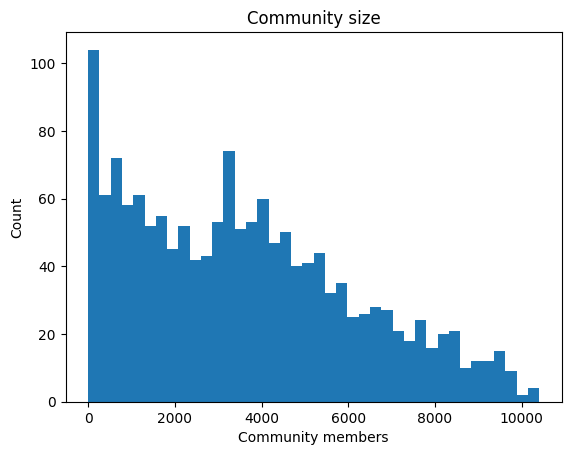

In [7]:
plt.hist(community_dict_bigger_than_one, bins=40)
plt.xlabel('Community members')
plt.ylabel('Count')
plt.title('Community size')
plt.show()

### Clean and tokenize abstracts 

In [8]:
def clean_and_tokenize(text):
    text = text.lower()  # Convert text to lowercase
    text = re.sub(r'\W', ' ', text)  # Remove non-alphanumeric characters
    tokens = nltk.tokenize.word_tokenize(text)# Tokenize text
    return tokens

Creating a dict for each **paper** with their words

In [9]:
## Tokenized words in each paper
if new_df:
    # {'01f02fae-97df-4207-a386-a1bc8ec0853b': "For stereoscopic optical see-through head-mounted display...
    abstracts = nx.get_node_attributes(G, 'abstract')
    
    # {'01f02fae-97df-4207-a386-a1bc8ec0853b': 'Modeling Physical Structure as Additional Constraints for Stereoscopic Optical See-Through Head-Mounted Display Calibration'
    titles = nx.get_node_attributes(G, 'title')

    # {'01f02fae-97df-4207-a386-a1bc8ec0853b': title + abstract}
    paper_dict = {key: titles.get(key, '') + ' ' + abstracts.get(key, '') for key in set(abstracts) | set(titles)}
    
    # paper_dict_clean['345a2369-8198-46db-8ebb-b3f622b35381'] = ['scalable', 'feature', 'extraction', 'for', 'coarse',
    paper_dict_clean = {key:  clean_and_tokenize(text) for key, text in paper_dict.items()}
    
    print('Pickeling...')
    pickle.dump(paper_dict_clean, open( "paper_dict_clean.pkl", "wb" ) )
    pickle.dump(abstracts, open( "abstracts.pkl", "wb" ) )
    pickle.dump(titles, open( "titles.pkl", "wb" ) )
    
else:
    
    with open("paper_dict_clean.pkl", 'rb') as f:
        paper_dict_clean = pickle.load(f)
    
    with open("abstracts.pkl", 'rb') as f:
        abstracts = pickle.load(f)
    
    with open("titles.pkl", 'rb') as f:
        titles = pickle.load(f)
    


Creating a dict for each **cluster** with all words from the papers it contains

In [10]:

if new_df:
    community_texts_clean = {new_list: [] for new_list in range(len(community_dict_bigger_than_one))}
    
    for cluster_id, paper_ids in enumerate(community_dict_bigger_than_one.values()):
        for paper_id in paper_ids:  
            community_texts_clean[cluster_id].extend(paper_dict_clean[paper_id[0]])          
    
    print('Pickling...')
    pickle.dump(community_texts_clean, open( "community_texts_clean.pkl", "wb" ) )
    
else:
    with open("community_texts_clean.pkl", 'rb') as f:
        community_texts_clean = pickle.load(f)
 
        
# Turn into nltk format
community_text_clean_text = { cluster_id: nltk.Text(text) for cluster_id, text in community_texts_clean.items() } 

# Example 
# {'345a2369-8198-46db-8ebb-b3f622b35381': <Text: scalable feature extraction for coarse to fine jpeg...>,
paper_dict_clean_text = { paper_id: nltk.Text(text) for paper_id, text in paper_dict_clean.items() } 

## TF-IDF analysis

TF for each **community**, looking at the 'document' as a cluster 

In [12]:
# TF for each community
if new_df:
    
    # TF_clusters[100] = Counter({'the': 28, 'of': 23,'in': 14,'we': 13,
    TF_clusters = {}

    for cluster_, text in enumerate(community_text_clean_text.values()):
        overall_freq = Counter()           
        try:
            fd = nltk.FreqDist(text)
            overall_freq = overall_freq + Counter(fd)
        except:
            print('Breaked')
            continue
            
        TF_clusters[cluster_] = overall_freq

    pickle.dump(TF_clusters, open( "TF_clusters.pkl", "wb" ) )

else:
    with open("TF_clusters.pkl", 'rb') as f:
        TF_clusters = pickle.load(f)

TF for each **paper** inside their community, looking at the 'document' as the paper

In [13]:
if new_df:    
    TF_papers = {}

    for cluster_, paper_ids in enumerate(community_dict_bigger_than_one.values()): 
        TF_papers[cluster_] = {}
        
        for paper_id in paper_ids:         
            overall_freq = Counter()     
                    
            try:
                text = paper_dict_clean_text[paper_id[0]]
                fd = nltk.FreqDist(text)
                overall_freq = overall_freq + Counter(fd)
                
            except:
                print('Breaked')
                continue
            
            TF_papers[cluster_][paper_id[0]] = overall_freq
            
    pickle.dump(TF_papers, open( "TF_papers.pkl", "wb" ) )
    
else:
    with open("TF_papers.pkl", 'rb') as f:
        TF_papers = pickle.load(f)
       

### TF-IDF for all communities

In [14]:
def get_top_n_items(dict_, n):
    # Sort the dictionary by value in descending order and get the top n items
    top_n_items = sorted(dict_.items(), key=lambda x: x[1], reverse=True)[:n]
    
    # Convert the list of tuples back to a dictionary
    return dict(top_n_items)

def tf_idf(cluster_id, counter):  
    # Total number of words in the cluster
    total_words = counter.total()
    
    return {word: (TF_clusters[cluster_id][word] / total_words) * np.log( N / word_count(word) ) for word in counter}

if new_df:

    # Number of clusters
    N = len(TF_clusters)
    
    tf_idf_all_communities = {i: tf_idf(i, TF_clusters[i]) for i in TF_clusters}
    top_tf_idf_all_communities = {i: get_top_n_items(tf_idf_all_communities[i], 40) for i in tf_idf_all_communities}
    
    print('Pickling...')
    pickle.dump(tf_idf_all_communities, open( "tf_idf_all_communities.pkl", "wb" ) )
    pickle.dump(top_tf_idf_all_communities, open( "top_tf_idf_all_communities.pkl", "wb" ) )
    
else:
    with open("tf_idf_all_communities.pkl", 'rb') as f:
        tf_idf_all_communities = pickle.load(f)
    with open("top_tf_idf_all_communities.pkl", 'rb') as f:
        top_tf_idf_all_communities = pickle.load(f)

### TF-IDF for each paper

In [71]:
def get_top_n_items(dict_, n):
    # Sort the dictionary by value in descending order and get the top n items
    top_n_items = sorted(dict_.items(), key=lambda x: x[1], reverse=True)[:n]
    
    # Convert the list of tuples back to a dictionary
    return dict(top_n_items)

def tf_idf_papers(counter): 
    # Total words in the current paper
    total_words = counter.total()

    return {word: (counter[word] / total_words) * np.log( N / word_count_papers[cluster_id][word] ) for word in counter}

if new_df:
    # Dict to store the word counts
    word_count_papers = defaultdict(lambda: defaultdict(int))

    for i in TF_papers:
        for paper in TF_papers[i].values():
            for word in paper:
                word_count_papers[i][word] += 1

    tf_idf_all_papers = {}
    top_tf_idf_all_papers = {}

    for cluster_id, papers in tqdm(TF_papers.items(), desc="Processing clusters"):
        # Number of papers inside the current cluster 
        N = len(TF_papers[cluster_id])

        tf_idf_all_papers[cluster_id] = {paper_id_: tf_idf_papers(counter_) for paper_id_, counter_ in papers.items()}
        top_tf_idf_all_papers[cluster_id] = {paper_id_: get_top_n_items(tf_idf_all_papers[cluster_id][paper_id_], 40) for paper_id_ in tf_idf_all_papers[cluster_id]}

    print('Pickling...')
    pickle.dump(tf_idf_all_papers, open( "tf_idf_all_papers.pkl", "wb" ) )
    pickle.dump(top_tf_idf_all_papers, open( "top_tf_idf_all_papers.pkl", "wb" ) )
    
else:
    with open("tf_idf_all_papers.pkl", 'rb') as f:
        tf_idf_all_papers = pickle.load(f)
    with open("top_tf_idf_all_papers.pkl", 'rb') as f:
        top_tf_idf_all_papers = pickle.load(f)

Processing clusters: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1515/1515 [03:14<00:00,  7.77it/s]


Pickling...


## User input box

Functions used for the user input

In [ ]:
### TF-IDF for user-input. At cluster level
def text_cluster(text):
    overall_freq = Counter() 
    text = nltk.Text(clean_and_tokenize(text))
           
    try:
        fd = nltk.FreqDist(text)
        overall_freq = overall_freq + Counter(fd)
        
    except:
        print('Breaked')
            
    return overall_freq

def text_idf(word):
    return max(1, sum(word in cluster for cluster in TF_clusters.values()))

def text_tf_idf(tf_words):
    tf_idf_scores = {}
    N = len(TF_clusters) 
    for word in tf_words:
        tf = TF_text[word]/TF_text.total()
        idfreq = np.log( N / text_idf(word) )
        tf_idf_scores[word] = tf*idfreq
            
    return tf_idf_scores

### Jaccard similarity
def jaccard_similarity(tfidf, keywords):
    keywords_40 = [x[0] for x in keywords]
    set_input_words = set(tfidf.keys())
    set_keywords = set(keywords_40)
    
    intersection = len(set_input_words & set_keywords)
    union = len(set_input_words | set_keywords)
    
    similarity = intersection / union if union != 0 else 0
    return similarity

### TF-IDF inside the cluster
def text_paper(text):
    overall_freq = Counter() 
    text = nltk.Text(clean_and_tokenize(text))
           
    try:
        fd = nltk.FreqDist(text)
        overall_freq = overall_freq + Counter(fd)
        
    except:
        print('Breaked')
            
    return overall_freq

def text_idf_paper(word):
    return max(1,sum(word in cluster for cluster in TF_papers[best_cluster].values()))

def text_tf_idf_paper(tf_words, best_cluster):
    N = len(TF_papers[best_cluster])
    tf_idf_scores = {} 
    for word in tf_words:
        tf = TF_paper[word]/TF_paper.total()
        idfreq = np.log(N / text_idf_paper(word))
        tf_idf_scores[word] = tf*idfreq
            
    return tf_idf_scores

The actual user input box

In [72]:
text = input()
print('The user input:\n', text)

# TF for the input text
TF_text = text_cluster(text)

# TF-IDF for the input text on cluster level
cLevel_tf_idf = text_tf_idf(TF_text)
cLevel_sorted = sorted(cLevel_tf_idf.items(), key=lambda x:x[1], reverse=True)[:12]
print('\n12 highest TF-IDF scores:')
print(cLevel_sorted)

# Similarity on cluster-level
sim_cluster = {}
for i in range(len(tf_idf_all_communities)):
    sim_cluster[i] = jaccard_similarity(top_tf_idf_all_communities[i], cLevel_sorted)
   
# Find the most similar clusters 
sorted_similarity = sorted(sim_cluster.items(), key=lambda x:x[1], reverse=True)[:5]
    
c1, c2, c3 = sorted_similarity[0][0], sorted_similarity[1][0], sorted_similarity[2][0]
clusters = [c1,c2,c3]

print('\n## Best matching clusters: ##')
print(c1, c2, c3)

########## PAPER LEVEL ##########
# TF on input text inside the choosen clusters
TF_paper = text_paper(text)

# TF-IDF words 
dLevel_sorted = {}
for i in clusters:
    c = text_tf_idf_paper(TF_paper, i)
    dLevel_sorted[i] = sorted(c.items(), key=lambda x:x[1], reverse=True)[:40]

#{585: {'73d121f9-0014-434c-b689-e1024ebb95f8': {0.03896103896103896}, 'f188c8be-987b-4fce-984a-95a5105e5a8e': {0.012658227848101266}},
sim_papers = {}
for cluster in clusters:
    sim_papers[cluster] = {}
    dLevel_words = dLevel_sorted[cluster]
    for n in TF_papers[cluster]:
        sim_papers[cluster][n] = jaccard_similarity(top_tf_idf_all_papers[cluster][n], dLevel_words)


sorted_similarity_papers = {}
for cluster in sim_papers:
    sorted_similarity_papers[cluster] = sorted(sim_papers[cluster].items(), key=lambda x:x[1], reverse=True)[:3]


for cluster in clusters:
    print('\n### Cluster', cluster, '- Papers with highest jaccard similarity ###')
    print('( Paper id, jaccard similarity score) ')
    for paper in sorted_similarity_papers[cluster]:
        print(paper)

for cluster in clusters:
    print('\n### Papers recommended for cluster', cluster, '###')
    for b in sorted_similarity_papers[cluster]:
        print('Title: ',titles[b[0]])
        print('Abstract: ', abstracts[b[0]], '\n')


The user input:
 A Heterogeneous System for Real-Time Detection with AdaBoost. 

12 highest TF-IDF scores:
[('adaboost', 0.4865257487530032), ('heterogeneous', 0.3790164125017026), ('detection', 0.2987157477459815), ('real', 0.20565556047466607), ('time', 0.12678731235853752), ('system', 0.11690914289835223), ('with', 0.017863691176416865), ('for', 0.008771466926679941), ('a', 0.0020727523870349334)]

## Best matching clusters: ##
275 388 860

### Cluster 275 - Papers with highest jaccard similarity ###
( Paper id, jaccard similarity score) 
('b8a1b824-0f91-4dbe-a4bf-ee36e1eece95', 0.06521739130434782)
('918c35a9-e938-4273-bec4-5b8ec5252daa', 0.0425531914893617)
('20b9ea3f-23cb-4c55-a3c4-b3b94df602df', 0.0)

### Cluster 388 - Papers with highest jaccard similarity ###
( Paper id, jaccard similarity score) 
('f8605647-8e39-4ffd-b90d-1cddab2cf87a', 0.06666666666666667)
('bb8f2ac2-1150-405e-b4eb-a1e1e8042b45', 0.06451612903225806)

### Cluster 860 - Papers with highest jaccard similarity 

# Approach 3

Example of how to make embeddings, build index and search papers.
Making the embeddings of the dataset takes quite a long time to run, ~3 hours on the HPC on GPU.
It is possible to run it on a subset of the data by setting use_subset=True which will greatly reduce computation time.
Embeddings and index are cached automatically but if they are not yet built, set make_embeddings and make_index to True.

In [ ]:
path_data = "./citation_dataset"

In [ ]:
from encoder import Search, benchmark

# remove use_subset to use the whole citation dataset.
S = Search(path_data, make_embeddings=True, make_index=True, use_subset=True)

In [ ]:
# print top_k nearest papers from search prompt.
search_prompt = "Test search prompt one two three"
S.search_index_vocal(search_prompt, top_k=5)

In [ ]:
# same as above but return distances and indices
distances, neighbor_indices = S.search_index([search_prompt], k=5)
print(neighbor_indices)

In [ ]:
# search by paper id instead of prompt
S.find_similar_papers(id="001eef4f-1d00-4ae6-8b4f-7e66344bbc6e", k=5)

In [ ]:
# runs search for 100 prompts and prints elapsed time.
benchmark()